# B Prime matrix operations

We are going to be using Alphagenome to interpret if a Transcription Factor is an activator or a repressor

### Existing DataSets

In [27]:
import seqlogo
import numpy as np
import pandas as pd
import anndata

In [2]:
from Bio import motifs
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.motifs import meme

In [8]:
from alphagenome.data import gene_annotation

from alphagenome.data import genome
from alphagenome.data import transcript as transcript_utils

In [174]:
from mapping import get_sorted_gene_order, generate_gene_id_name_map, get_master_regulator_list, get_TF_lists, get_a_matrix_threshold, load_htf_motifs, generate_gene_id_name_map

from genome_utils import write_meme_format, parse_fasta, write_df_to_meme

from constants import HTF_MOTIFS_DIR, REFERENCE_GENOME_PATH, GENCODE_ANNOTATION_PATH, REFERENCE_GTF_HG38_PATH, REFERENCE_DIR

master_regulator_list = get_master_regulator_list()
repressorlist, activatorlist, conflictedlist, tf_list = get_TF_lists()

gene_id_name_map, gene_name_id_map = generate_gene_id_name_map()

total master regulators 439
 Total Activators : 174
Total Reprossors : 705
Total Conflicted : 729
Total Transcription Factors : 1608
Extracted 43945 mappings from 73467 ensembl lines
Extracted 38606 mappings from gene id gtf file
Total Mappings Extracted 59979


### Validation

To begin with, we take a single Trancription Factor and look at how it behaves with a target gene - Activates or repress, based on existing data 

In [30]:

b_matrix = anndata.read_h5ad('/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/operations/B_matrices_true.h5ad')

genes = b_matrix.var_names
TFs = b_matrix.obs_names


gene_counts = len(genes)
TF_counts = len(TFs)


print('TFs : ', gene_counts)
print('Genes : ' , TF_counts)

TFs :  19782
Genes :  1608


In [4]:

def load_consensus(gene, scale=1000):
    gene_id_name_map, gene_name_id_map = generate_gene_id_name_map()
    
    gene_id = gene_name_id_map.get(gene)
    motif_df = load_htf_motifs()

    try:
        
        gene_cisbp_id = motif_df[((motif_df['Ensembl ID'] == gene_id) & (motif_df['Best Motif(s)? (Figure 2A)'] == 'TRUE'))]['CIS-BP ID'].values[0]
    
    except:
        print('unable to find motif for gene in HTF')
        return None
        
    
    print(f'Gene CIS-BP ID : {gene_cisbp_id}')
    
    gene_motif_path = f'{HTF_MOTIFS_DIR}/{str(gene_cisbp_id)}.txt'
    
    print(gene_motif_path)
    
    gene_pwm = pd.read_csv(gene_motif_path, sep='\t')
    
    # NOTE: THese vales are probabilites so PPM matrices where each column adds up to one
    
    df = gene_pwm
    counts = {
        nt: (df[nt].values * scale).astype(int).tolist()
        for nt in ["A", "C", "G", "T"]
    }
    
    # counts = {
    #     'A': list(df['A']),
    #     'C': list(df['C']),
    #     'G': list(df['G']),
    #     'T': list(df['T']),
    # }
    
    motif = motifs.Motif(counts=counts)
    motif.name = gene
    motif.alphabet = "ACGT"
    motif.pseudocounts = 0.1
    
    # Print or work with the motif
    print(motif.pwm)  # Position Weight Matrix
    
    consensus = motif.consensus
    print("Consensus sequence:", consensus)
    return consensus, motif, gene_pwm


In [5]:
tempdir = '/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/temp'

In [6]:
gene = 'PRRX1'
censensus, motif, gene_pwm = load_consensus(gene)

savepath = f'{tempdir}/{gene}.meme'

print('saving to path', savepath)

write_df_to_meme(gene_pwm, savepath, gene)
# write_meme_format(motif, savepath)

print(gene_pwm)

Extracted 43945 mappings from 73467 ensembl lines
Extracted 38606 mappings from gene id gtf file
Total Mappings Extracted 59979
Gene CIS-BP ID : M06029_1.94d
/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/data/TF_MOTIFS/HTF_PWMs/M06029_1.94d.txt
        0      1      2      3      4      5      6      7
A:   0.16   0.05   0.84   1.00   0.01   0.03   0.47   0.27
C:   0.27   0.01   0.04   0.00   0.01   0.06   0.04   0.18
G:   0.18   0.02   0.08   0.00   0.02   0.04   0.41   0.38
T:   0.40   0.92   0.04   0.00   0.96   0.87   0.09   0.17

Consensus sequence: TTAATTAG
saving to path /nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/temp/PRRX1.meme
   Pos         A         C         G         T
0    1  0.157545  0.266382  0.178634  0.397439
1    2  0.047441  0.005250  0.024859  0.922450
2    3  0.839463  0.035269  0.080866  0.044402
3    4  0.999874  0.000000  0.000126  0.000000
4    5  0.008424  0.008142  0.020273  0.963162
5    6  0.029379  0.064416  0.039462  0.866744
6    7  0.

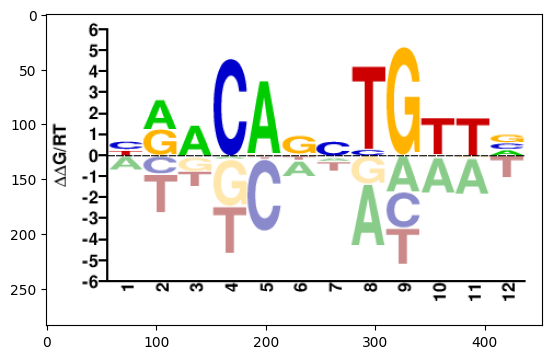

In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

image_path = '/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/data/TF_MOTIFS/Homo_sapiens_2025_07_21_6_25_pm/logos_all_motifs/M04322_3.00_fwd.png'

img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)

# Show the plot window
plt.show()

In [9]:


gtf = pd.read_feather(REFERENCE_GTF_HG38_PATH)

# Filter to protein-coding genes and highly supported transcripts.
gtf_transcript = gene_annotation.filter_transcript_support_level(
    gene_annotation.filter_protein_coding(gtf), ['1']
)

# Define an extractor that fetches only the longest transcript per gene.
gtf_longest_transcript = gene_annotation.filter_to_longest_transcript(
    gtf_transcript
)
longest_transcript_extractor = transcript_utils.TranscriptExtractor(
    gtf_longest_transcript
)


print(longest_transcript_extractor)

In [14]:
gtf.keys()

Index(['Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand',
       'Frame', 'gene_id', 'gene_type', 'gene_name', 'level', 'tag',
       'transcript_id', 'transcript_type', 'transcript_name',
       'transcript_support_level', 'havana_transcript', 'exon_number',
       'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid',
       'artif_dupl'],
      dtype='object')

In [147]:
gtf = pd.read_feather(REFERENCE_GTF_HG38_PATH)

In [168]:
# helper functions

        
import matplotlib.pyplot as plt
    


def parse_unique_ids(value):
    return value.split('.')[0]

def parse_id_attr(row, key, operation = parse_unique_ids):
    resdict = {}
    for key in keys:
        resdict[key] = operation(row[key])
        
    return pd.Series(resdict)

def pick_best_transcript(group):
    under_100kb = group[group["length"] <= 100000]
    if not under_100kb.empty:
        return under_100kb.sort_values("length", ascending=False).iloc[0]
    else:
        return group.sort_values("length", ascending=True).iloc[0]
        # group["dist_to_100kb"] = (group["length"] - 100_000).abs()
        # return group.sort_values("dist_to_100kb").iloc[0]



def plot_distribution(read_type, df, field):
    # Checking average gene length 
    
    
    mean_val = df[field].mean()
    median_val = df[field].median()
    max_val = df[field].max()
    
    print(f"Total {read_type}s: {len(df)}")
    print(f"Median {read_type} length: {median_val:,.0f} bp")
    print(f"Mean {read_type} length: {mean_val:,.0f} bp")
    print(f"Max {read_type} length: {max_val:,.0f} bp")
    
    
    plt.figure(figsize=(10,6))
    plt.hist(df[field], bins=100, color='skyblue', edgecolor='black', log=True)
    
    plt.axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='r', linestyle=':', label=f'Median: {median_val:.2f}')

    
    plt.legend()

    plt.xlabel(f'{read_type} length (bp)')
    plt.ylabel('Frequency (log scale)')
    plt.title(f'Distribution of {read_type} Lengths (GENCODE v46)')
    plt.xlim(0, 2000000)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    # plt.savefig('figures/{read_type}_{field}s.png')


In [125]:
# Checking number of protein coding genes

unique_genes_df = gtf[gtf['Feature'] == 'gene'].copy()


keys = ['gene_id']
unique_genes_df[keys] = unique_genes_df.apply(
    parse_id_attr,
    axis=1,
    args=(keys, parse_unique_ids)
)

unique_genes_df = unique_genes_df[unique_genes_df['gene_type'] == 'protein_coding']

# Comparison of genes we have from different sources

genes_from_gtf = set(list(unique_genes_df.drop_duplicates("gene_id")['gene_id']))
genes_from_a_matrix = set(genes)

print(f'Total number of protein coding genes from GTF: {len(genes_from_gtf)}')
print(f'Total number of genes from A Matrix: {len(genes_from_a_matrix)}')
print(f'Total number of intersection: {len(genes_from_gtf.intersection(genes_from_a_matrix))}')


Total number of protein coding genes from GTF: 20065
Total number of genes from A Matrix: 19782
Total number of intersection: 19267


In [129]:
genes_df = gtf[gtf['Feature'] == 'gene'].copy()

keys = ['gene_id']
genes_df[keys] = genes_df.apply(
    parse_id_attr,
    axis=1,
    args=(keys, parse_unique_ids)
)

In [130]:
genes_df = genes_df[genes_df['gene_id'].isin(genes)].copy()

# genes_df = genes_df[genes_df['gene_type'] == 'protein_coding']


# calculate the length of each transcript which can then be filtered and ordered
genes_df['length'] = genes_df['End'] - genes_df['Start'] + 1


Total Genes: 19781
Median Gene length: 26,447 bp
Mean Gene length: 67,770 bp
Max Gene length: 2,473,540 bp


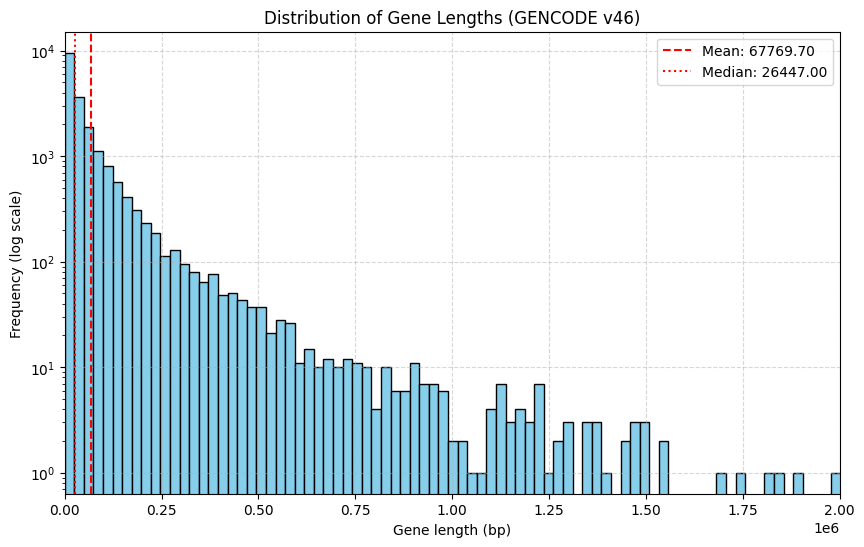

In [136]:

import matplotlib.pyplot as plt

# Checking average gene length 
read_type = 'Gene'
df = genes_df.copy()
attr = 'length'

plot_distribution(read_type, df, attr)



In [170]:
transcripts = gtf[gtf['Feature'] == 'transcript'].copy()


keys = ['gene_id', 'gene_type', 'transcript_id']
transcripts[keys] = transcripts.apply(
    parse_id_attr,
    axis=1,
    args=(keys, parse_unique_ids)
)

In [171]:
# WE extract the protein coding genes present in the B matrix
transcripts = transcripts[transcripts['gene_id'].isin(genes)].copy()

# calculate the length of each transcript which can then be filtered and ordered
transcripts['length'] = transcripts['End'] - transcripts['Start'] + 1

# transcripts are rarely greater than 100kb 
# transcripts = transcripts[transcripts['length'] < 100000].copy()


Total Transcripts: 170826
Median Transcript length: 16,145 bp
Mean Transcript length: 46,027 bp
Max Transcript length: 2,471,658 bp


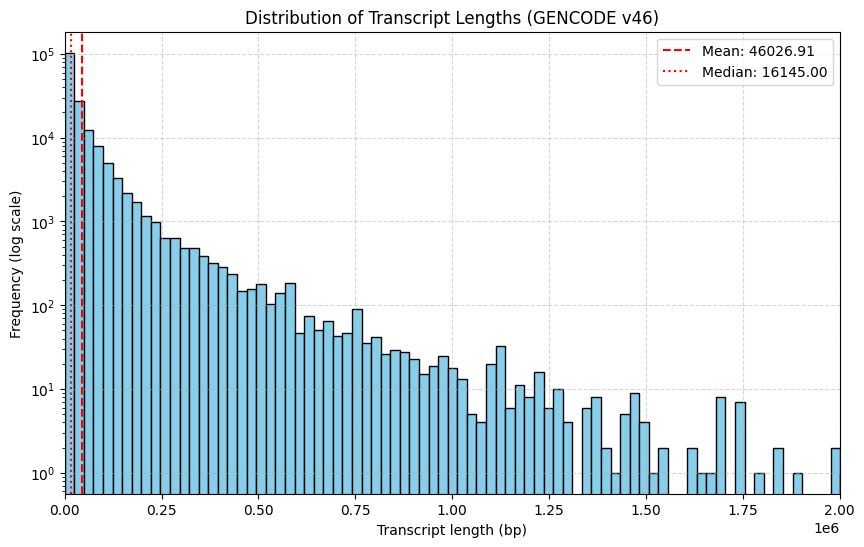

In [172]:

import matplotlib.pyplot as plt

# Checking average gene length 
read_type = 'Transcript'
df = transcripts.copy()
attr = 'length'

plot_distribution(read_type, df, attr)



In [90]:
transcript_to_gene = transcripts.copy()

transcript_to_gene = transcript_to_gene.merge(genes_df[['gene_id', 'length', 'Start']], on='gene_id', how='left')


# TSS occurs before the Gene start

transcript_to_gene['TSS_gene_distance'] = transcript_to_gene['Start_x'] - transcript_to_gene['Start_y'] 
print(transcript_to_gene)

Total TSS_gene_lengths: 170826
Median TSS_gene_length length: 1,835 bp
Mean TSS_gene_length length: 26,717 bp
Max TSS_gene_length length: 2,424,962 bp


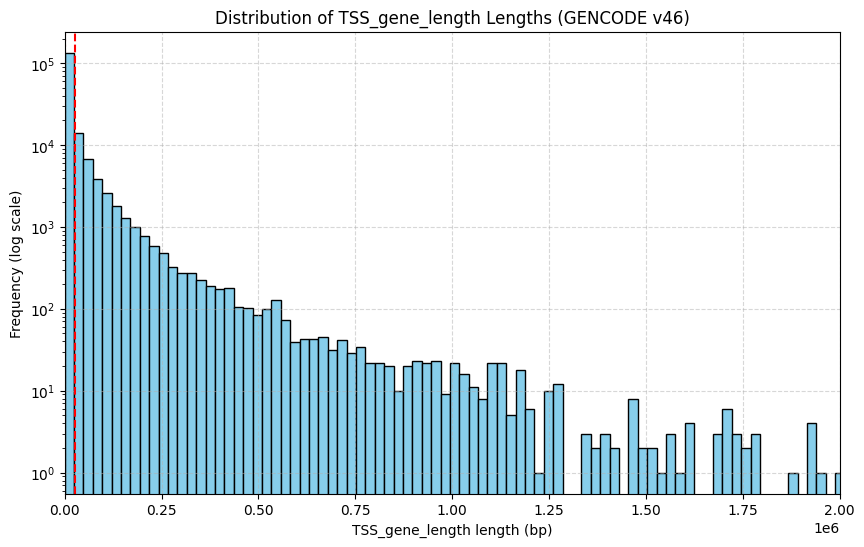

In [101]:

import matplotlib.pyplot as plt

# Checking average TSS to gene length 

read_type = 'TSS_gene_length'
df = transcript_to_gene.copy()
field = 'TSS_gene_distance'

plot_distribution(read_type, df, field)


### Transcript operations

We calculate the TSS as the start of the transcript site. Transcripts are the RNA transcripts for a particular gene. We know that transcripts should be < 100kb, but in case there is no transcript <100kb for a gene, we take the smallest transcript

/tmp/ipykernel_1956475/4168756671.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_transcripts = transcripts.groupby("gene_id", group_keys=False).apply(pick_best_transcript, include_groups=True)


Total Best Transcripts: 19781
Median Best Transcript length: 23,606 bp
Mean Best Transcript length: 35,079 bp
Max Best Transcript length: 1,369,274 bp


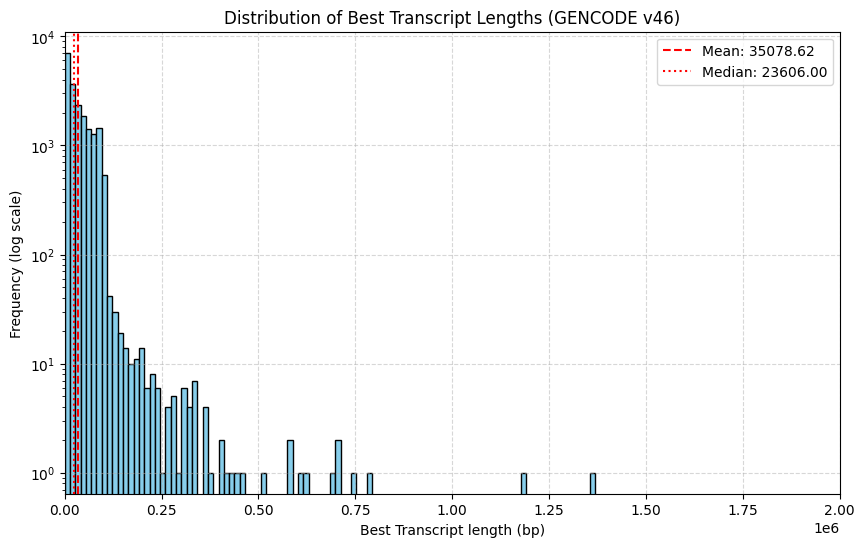

In [186]:


# calculate the length of each transcript which can then be filtered and ordered
transcripts['length'] = transcripts['End'] - transcripts['Start'] + 1
# print(transcripts)

best_transcripts = transcripts.groupby("gene_id", group_keys=False).apply(pick_best_transcript, include_groups=True)

# print(best_transcripts)
# 
# best_transcripts = transcripts.groupby("gene_id", group_keys=False).apply(
#     lambda group: pick_best_transcript(group), include_groups=False
# )


import matplotlib.pyplot as plt

# Checking average gene length 
read_type = 'Best Transcript'
attr = 'length'

plot_distribution(read_type, best_transcripts, attr)




In [188]:
best_transcripts.keys()

Index(['Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand',
       'Frame', 'gene_id', 'gene_type', 'gene_name', 'level', 'tag',
       'transcript_id', 'transcript_type', 'transcript_name',
       'transcript_support_level', 'havana_transcript', 'exon_number',
       'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid',
       'artif_dupl', 'length'],
      dtype='object')

In [190]:
# Get the TSS FLanking region
def get_tss_flank(row, flank=1000):
    if row["Strand"] == "+":
        tss = row["Start"]
        flank_start = max(0, tss - flank)
        flank_end = tss + flank
    else:
        tss = row["End"]
        flank_start = max(0, tss - flank)
        flank_end = tss + flank
    return pd.Series([flank_start, flank_end])


best_transcripts[["flank_start", "flank_end"]] = best_transcripts.apply(get_tss_flank, axis=1, args=(10000,))



bed = best_transcripts[["Chromosome", "flank_start", "flank_end", "gene_id", "Strand", "Score"]].copy()
bed = bed[["Chromosome", "flank_start", "flank_end", "gene_id", "Score", "Strand"]]

bed_csv = f"{REFERENCE_DIR}/protein_coding_tss_flank_10kb.bed"
bed.to_csv(bed_csv, sep="\t", header=False, index=False)


In [9]:
from constants import REFERENCE_CHROM_SIZES_PATH, REFERENCE_GENES_BED_PATH, REFERENCE_GENOME_PATH

print(REFERENCE_CHROM_SIZES_PATH)
print(REFERENCE_GENES_BED_PATH)
print(REFERENCE_GENOME_PATH)

/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/data/REFERENCE/hg38.chrom.sizes
/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/data/REFERENCE/genes.bed
/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/data/REFERENCE/hg38.fa


### Operations

In order to fetch the promoter regions for each gene, We download the reference genome, and use bedtools to fetch the scaffold regions

- To keep only the clean chromosomes : grep -v "_" genes.bed > genes.filtered.bed 
- To extract Scaffold regions of +1000 and -100 :  bedtools flank -i /scratch/indikar_root/indikar1/shared_data/HWG/data/REFERENCE/genes.filtered.bed -g /scratch/indikar_root/indikar1/shared_data/HWG/data/REFERENCE/hg38.chrom.sizes -l 1000 -r 100 -s > promoters.bed
- To extract the regions from the reference genome : bedtools getfasta -fi /nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/data/REFERENCE/hg38_genome/ncbi_dataset/data/GCF_000001405.40/GCF_000001405.40_GRCh38.p14_genomic.fna -bed promoters.bed > promoters.fa
- Now scanning for motifs with FIMO : fimo --oc fimo_out motif.meme promoters.fa

For a slight change in logic.
instead of using 1000 on 5' and 100 on 3', we consider +- 1kb around the Transcription Start Site as the flank for promoter region.

In [10]:
fimo_file = '/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/temp/promoter_operations/fimo_out/fimo.tsv'

pd.read_csv(fimo_file, sep='\t')

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,PRRX1,NaN,chrM,10021.0,10028.0,-,10.7822,0.000022,1.0,TTAATTGG
1,PRRX1,NaN,chrM,10021.0,10028.0,-,10.7822,0.000022,1.0,TTAATTGG
2,PRRX1,NaN,chrM,10021.0,10028.0,-,10.7822,0.000022,1.0,TTAATTGG
3,PRRX1,NaN,chrM,10021.0,10028.0,-,10.7822,0.000022,1.0,TTAATTGG
4,PRRX1,NaN,chrM,10021.0,10028.0,-,10.7822,0.000022,1.0,TTAATTGG
...,...,...,...,...,...,...,...,...,...,...
41575,PRRX1,NaN,chr1,248859934.0,248859941.0,-,10.4059,0.000088,1.0,CTAATTAG
41576,PRRX1,NaN,chr1,248859934.0,248859941.0,-,10.4059,0.000088,1.0,CTAATTAG
41577,# FIMO (Find Individual Motif Occurrences): Ve...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41578,# The format of this file is described at http...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd
from pyfaidx import Fasta
from Bio.Seq import Seq
from collections import defaultdict

# === Parameters ===
gene_name = "PRRX1"
genome_fasta = "GRCh38.fa"  # Must be indexed with samtools faidx
gtf_file = "genes.gtf"
fimo_file = "fimo.tsv"
replacement_motif = "ATGCGT"  # Replacement motif
output_original = "gene_region_original.fa"
output_replaced = "gene_region_replaced.fa"
region_size = 1_000_000  # 1Mbp

# === Step 1: Get gene coordinates from GTF ===
def get_gene_tss(gtf_file, gene_name):
    gtf = pd.read_csv(gtf_file, sep="\t", comment="#", header=None,
                      names=["chr", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"])
    gene_rows = gtf[(gtf["feature"] == "gene") & (gtf["attribute"].str.contains(f'gene_name "{gene_name}"'))]
    if gene_rows.empty:
        raise ValueError(f"Gene {gene_name} not found in GTF.")
    
    row = gene_rows.iloc[0]
    chrom = row["chr"]
    strand = row["strand"]
    tss = row["start"] if strand == "+" else row["end"]
    return chrom, strand, tss

# === Step 2: Extract 1Mbp region around TSS ===
def get_region(chrom, tss, region_size, fasta):
    half = region_size // 2
    start = max(0, tss - half)
    end = tss + half
    seq = fasta[chrom][start:end].seq
    return start, end, seq

# === Step 3: Replace motifs from FIMO ===
def replace_motifs_in_sequence(seq, chrom, start_offset, fimo_df, replacement, strand="+"):
    matches = fimo_df[fimo_df["sequence_name"] == chrom].copy()
    matches = matches[(matches["start"] >= start_offset + 1) & (matches["stop"] <= start_offset + len(seq))]

    # Convert to relative positions
    matches["rel_start"] = matches["start"] - 1 - start_offset
    matches["rel_stop"] = matches["stop"] - start_offset

    matches = matches.sort_values("rel_start", ascending=False)

    for _, row in matches.iterrows():
        s, e, match_strand = int(row["rel_start"]), int(row["rel_stop"]), row["strand"]
        rep_seq = str(Seq(replacement).reverse_complement()) if match_strand == "-" else replacement
        seq = seq[:s] + rep_seq + seq[e:]
    return seq

# === Run the pipeline ===
# Step 1
chrom, strand, tss = get_gene_tss(gtf_file, gene_name)

# Step 2
fasta = Fasta(genome_fasta)
region_start, region_end, original_seq = get_region(chrom, tss, region_size, fasta)

# Step 3
fimo_df = pd.read_csv(fimo_file, sep="\t")
modified_seq = replace_motifs_in_sequence(original_seq, chrom, region_start, fimo_df, replacement_motif, strand)

# === Output FASTA files ===
with open(output_original, "w") as f:
    f.write(f">{gene_name}_original_{chrom}:{region_start}-{region_end}\n{original_seq}\n")

with open(output_replaced, "w") as f:
    f.write(f">{gene_name}_replaced_{chrom}:{region_start}-{region_end}\n{modified_seq}\n")

print("✅ Done! Original and replaced sequences saved.")


In [7]:
GENCODE_ANNOTATION_PATH

'/nfs/turbo/umms-indikar/shared/projects/HWG/data/HWG/data/REFERENCE/gencode.v43.annotation.gtf.gz'